In [4]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
def load_and_process_bedSVM(file_path, X, y, nn, meann, varr):
    # Define column headers and columns to use
    columns = ['chr', 'start', 'end', 'cn', 'mean_cov', 'len', 'pcn', 'is_pass', 'rep_len', 'rep_pct',
               'discard1', 'discard2', 'discard3', 'mean_bin', 'clip', 'poss', 'ref_all', 'alt_all', 'r_ct', 'alt_ct']
    columns_to_discard = ['pcn', 'is_pass', 'rep_len', 'r_ct', 'alt_ct', 'ref_all', 'alt_all', 'poss',
                          'discard1', 'discard2', 'discard3', 'end', 'rep_pct', 'mean_cov']
    use_cols = [col for col in columns if col not in columns_to_discard]

    # Load the data
    df1 = pd.read_csv(file_path, sep='\t', header=None, names=columns, usecols=use_cols)

    # Group and aggregate data
    grouped_df = df1.groupby(['chr', 'len', 'cn']).agg(custom_agg).reset_index()

    # Add mean and variance columns
    grouped_df['meann'] = int(meann)
    grouped_df['varr'] = int(varr)

    # Encode 'chr' column
    label_encoder = LabelEncoder()
    grouped_df['chr'] = label_encoder.fit_transform(grouped_df['chr'])

    new_columns = {}

    for col in ['mean_bin', 'clip']:
        # Create a DataFrame from the expanded lists
        expanded_data = [x[:max_len] + [0] * (max_len - len(x)) for x in grouped_df[col]]
        new_columns[col] = pd.DataFrame(expanded_data, index=grouped_df.index)
        new_columns[col].columns = [f'{col}_{i}' for i in range(max_len)]

    # Concatenate all new columns with the original DataFrame
    grouped_df = pd.concat([grouped_df] + list(new_columns.values()), axis=1)

    # Drop unnecessary columns
    grouped_df.drop(['mean_bin', 'clip', 'cn'], axis=1, inplace=True)

    # Optionally sample a subset of data
   # if nn == 0:
    #    grouped_df = grouped_df.sample(frac=0.1, random_state=42)

    # Convert DataFrame to NumPy array
    df_array = np.array(grouped_df.values, dtype=float)
    new_y = np.full(df_array.shape[0], nn)

    # Concatenate arrays
    X = np.concatenate((X, df_array), axis=0) if X is not None else df_array
    y = np.concatenate((y, new_y), axis=0) if y is not None else new_y

    return X, y

In [6]:
#slop of 500 was used upstream
def custom_agg(series):
    if series.name == 'start':
        return series.iloc[0] + 500
    elif series.name == 'end':
        return series.iloc[-1] - 500
 #   elif series.nunique() == 1:
 #       return series.iloc[0]
    else:
        return series.tolist()

In [7]:
#lb, ub of len
min_len = 50
max_len = 2000


samples = {}
c=0
with open("/Users/red/Downloads/drive-download-20231213T041531Z-001/test_genomes_cov.txt") as s:
  for line in s.readlines():
    if c<5:
      line=line.rstrip()
      line=line.split("\t")
      samples[line[0]] = [line[1], line[2]]
      c+=1
print(samples)

{'HG00621': ['40', '136'], 'HG00673': ['40', '130'], 'HG00733': ['34', '67'], 'HG00735': ['43', '129'], 'HG00741': ['38', '117']}


In [8]:

X, y = None, None
X_t, y_t = None, None

c = len(samples)

l=1
for sample,v in samples.items():
    print(sample)
    
    filepath1 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.copy0_COMB.bed"
    filepath0 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.neutral0_COMB.bed"
   
    if c==l:
        X_t, y_t = load_and_process_bedSVM(filepath0, X, y, 0, v[0], v[1])
        X_t, y_t = load_and_process_bedSVM(filepath1, X, y, 1, v[0], v[1])
    else:
        X, y = load_and_process_bedSVM(filepath0, X, y, 0, v[0], v[1])
        X, y = load_and_process_bedSVM(filepath1, X, y, 1, v[0], v[1])
    l+=1




HG00621
HG00673
HG00733
HG00735
HG00741


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [25]:
#create balanced independent set

data = pd.DataFrame(X_t)
data['label'] = y_t

# Separate the data by class
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

n_samples = min(len(class_0), len(class_1))

# Sample from each class
class_0_sample = class_0.sample(n=n_samples, random_state=42)
class_1_sample = class_1.sample(n=n_samples, random_state=42)

# Combine the samples to create a balanced test set
balanced_test_set = pd.concat([class_0_sample, class_1_sample])

# Split the balanced test set into features and labels
X_ind_test = balanced_test_set.drop('label', axis=1)
y_ind_test = balanced_test_set['label']

In [31]:
# Assuming X_t and y_t are NumPy arrays

# Get boolean masks for each class
mask_class_0 = y_t == 0
mask_class_1 = y_t == 1

# Separate the data by class
X_class_0 = X_t[mask_class_0]
X_class_1 = X_t[mask_class_1]

y_class_0 = y_t[mask_class_0]
y_class_1 = y_t[mask_class_1]

# Determine the number of samples per class for the test set
n_samples = min(len(X_class_0), len(X_class_1))

# Generate random indices for sampling
indices_0 = np.random.choice(len(X_class_0), n_samples, replace=False)
indices_1 = np.random.choice(len(X_class_1), n_samples, replace=False)

# Sample from each class
X_class_0_sample = X_class_0[indices_0]
X_class_1_sample = X_class_1[indices_1]

y_class_0_sample = y_class_0[indices_0]
y_class_1_sample = y_class_1[indices_1]

# Combine the samples to create a balanced test set
X_ind_test = np.vstack((X_class_0_sample, X_class_1_sample))
y_ind_test = np.concatenate((y_class_0_sample, y_class_1_sample))

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(X_ind_test))
X_ind_test = X_ind_test[shuffle_indices]
y_ind_test = y_ind_test[shuffle_indices]


AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

X_ind_test_scaled = scaler.transform(np.array(X_ind_test))

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize SVM classifier with a specific kernel, e.g., RBF
clf = SVC(kernel='rbf')

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9896617740906191
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6699
           1       0.99      0.94      0.96      1136

    accuracy                           0.99      7835
   macro avg       0.99      0.97      0.98      7835
weighted avg       0.99      0.99      0.99      7835



In [34]:
# Make predictions on the ind test set
y_ind_pred = clf.predict(X_ind_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_ind_test, y_ind_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9770996906971211
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6699
           1       0.99      0.94      0.96      1136

    accuracy                           0.99      7835
   macro avg       0.99      0.97      0.98      7835
weighted avg       0.99      0.99      0.99      7835



In [36]:
from sklearn.metrics import confusion_matrix


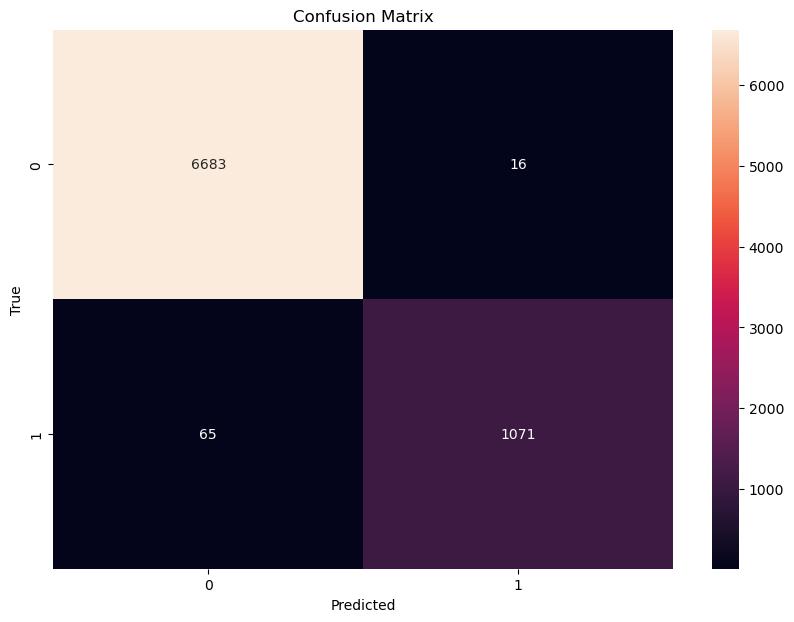

In [37]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

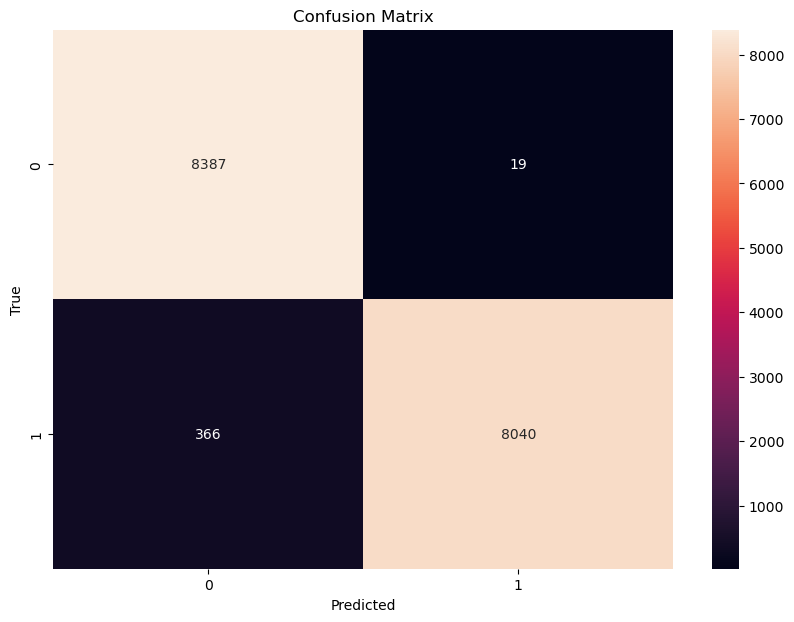

In [38]:
# Create the confusion matrix
cm1 = confusion_matrix(y_ind_test, y_ind_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm1, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']}

# Grid search for best parameters
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END ........................C=10, gamma=0.1,

In [9]:
# Retrain with best parameters
best_clf = SVC(**grid.best_params_)
best_clf.fit(X_train, y_train)

# Re-evaluate
y_pred_best = best_clf.predict(X_test)
print(f"Accuracy with best parameters: {accuracy_score(y_test, y_pred_best)}")


Accuracy with best parameters: 0.5826446280991735


In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

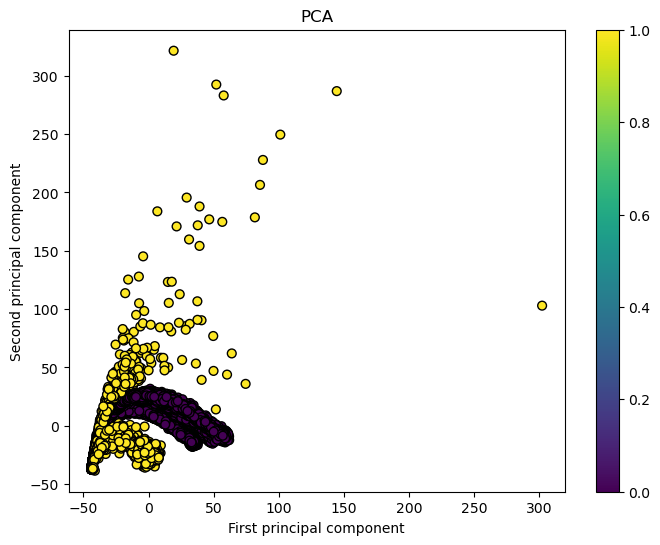

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.colorbar()
plt.show()

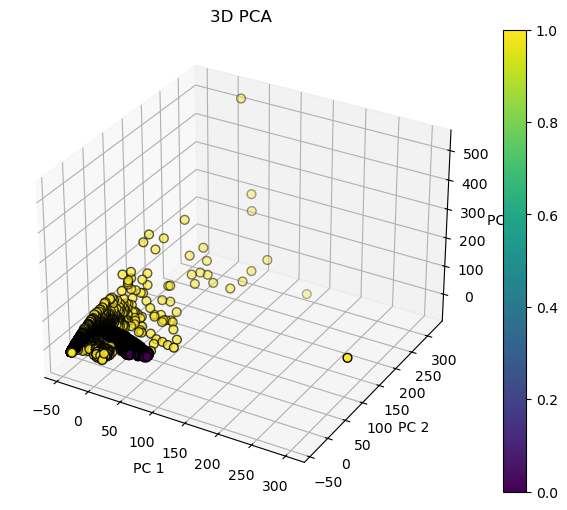

In [12]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D PCA")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.colorbar(scatter)
plt.show()

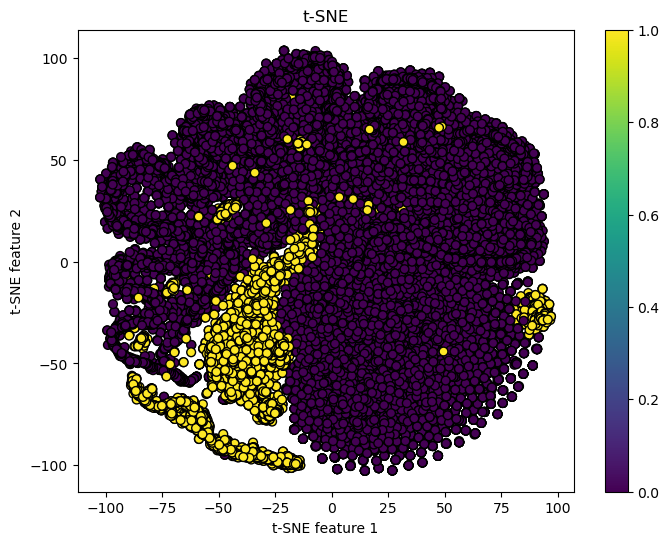

In [16]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("t-SNE")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar()
plt.show()

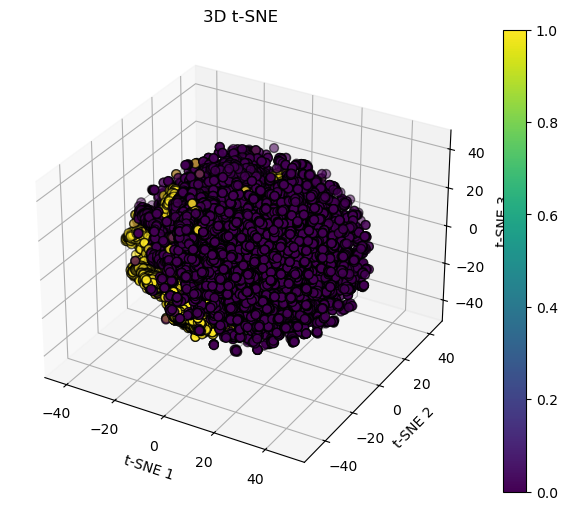

In [13]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D t-SNE")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.colorbar(scatter)
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/red/.conda/envs/sb/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


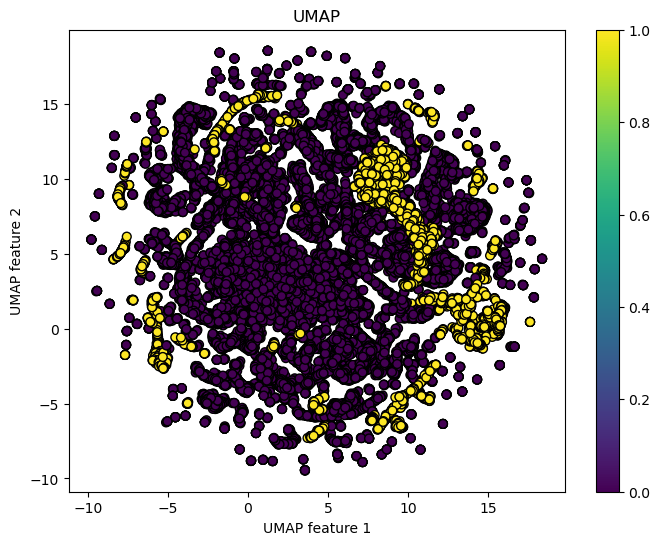

In [17]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("UMAP")
plt.xlabel("UMAP feature 1")
plt.ylabel("UMAP feature 2")
plt.colorbar()
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/red/.conda/envs/sb/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


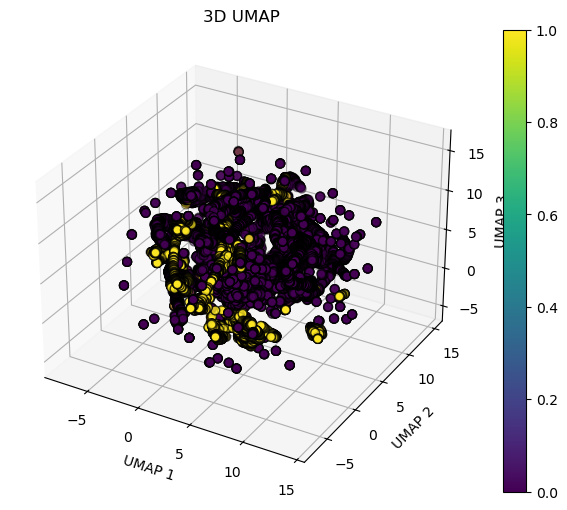

In [14]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3)
X_umap = umap_model.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D UMAP")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.colorbar(scatter)
plt.show()